In [1]:
# Loading necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
%matplotlib inline
import seaborn as sns
import math
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD, RMSF
from MDAnalysis.analysis.pca import PCA, cosine_content
from MDAnalysis.analysis import diffusionmap
import pandas as pd

/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


This jupyter script has been used to concatenate and analyze 

Alignment and Concatenation of subsequent trajectories 

In [2]:
import nglview

In [3]:
data_path = "../../data/02_processed/02_prod/"
sel = 'name CA'


#concatenation 

traj_1 = data_path + "prod_1/step5_production_nbc.xtc"
traj_2 = data_path + "prod_2/step5_prod_2_nbc.xtc"
traj_3 = data_path + "prod_3/step5_prod_3_nbc.xtc"
traj_4 = data_path + "prod_4/step5_prod_4_nbc.xtc"


config_file = data_path + "step5_production.tpr"
concat_traj_file = data_path + "prod_cat.xtc"

already_done = True 
if not already_done: 
    conc_traj = mda.Universe(config_file, [traj_1,traj_2, traj_3, traj_4])
    ref_traj = mda.Universe(config_file, traj_1)
    
    ref_traj.trajectory[0]
    aligner = AlignTraj(conc_traj,ref_traj,select=sel,filename = concat_traj_file)
    aligner.run()

In [4]:
aligned_traj = mda.Universe(config_file, concat_traj_file)
ref_traj = mda.Universe(config_file, concat_traj_file)
ref_traj.trajectory[0]

< Timestep 0 with unit cell dimensions [71.010994 71.010994 71.010994 90.       90.       90.      ] >

In [5]:
view = nglview.show_mdanalysis(aligned_traj)
view

NGLWidget(max_frame=843)

                                                            
                                                        RMSD and RMSF 

Text(0, 0.5, 'RMSD $[\\AA]$')

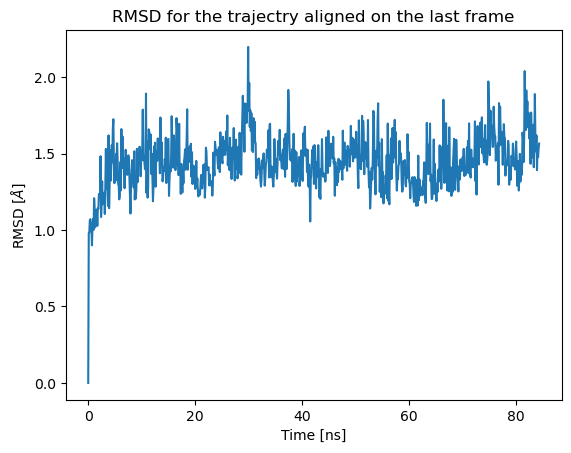

In [6]:
R = RMSD(aligned_traj, ref_traj, select=sel).run()

plt.title("RMSD for the trajectry aligned on the last frame")
plt.plot(R.results.rmsd[:,0] / 10, R.results.rmsd[:,2])
plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD $[\AA]$')

Text(0, 0.5, 'RMSF')

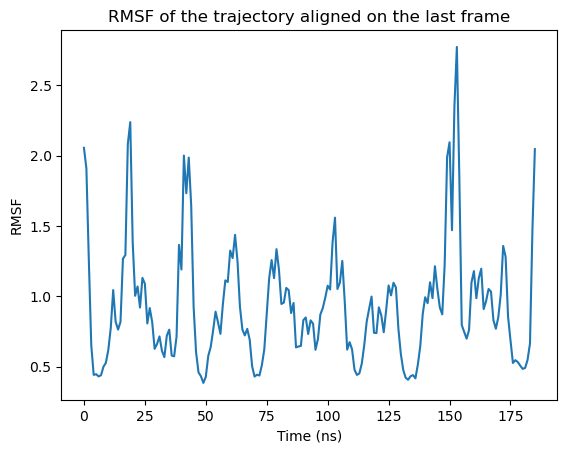

In [7]:
RF = RMSF(aligned_traj.select_atoms(sel)).run()

plt.title('RMSF of the trajectory aligned on the last frame')
plt.plot(RF.results.rmsf)
plt.xlabel('Time (ns)')
plt.ylabel('RMSF')

Principal Component Analysis 

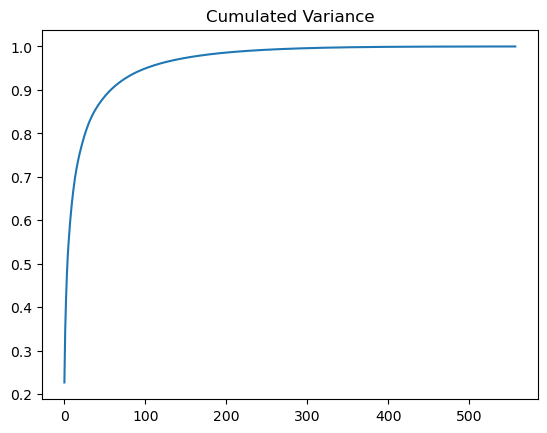

In [8]:
pca = PCA(aligned_traj, select=sel)
pca.run()


plt.title('Cumulated Variance')
plt.plot(pca.results.cumulated_variance)

In [9]:
pca_space = pca.transform(aligned_traj.select_atoms(sel),2)
pca_data = pd.DataFrame(pca_space, columns=['first_comp','second_comp'])
pca_data["group"] = pca_data.index // 40
pca_data

,first_comp,second_comp,group
0,3.069835,-0.967948,0
1,-2.062919,-4.251721,0
2,-2.614393,-1.636565,0
3,-2.852292,-4.973592,0
4,2.185837,-0.176823,0
...,...,...,...
839,-3.812257,2.638374,20
840,-5.526237,2.847574,21
841,-3.517652,5.615514,21
842,-3.404261,6.479385,21


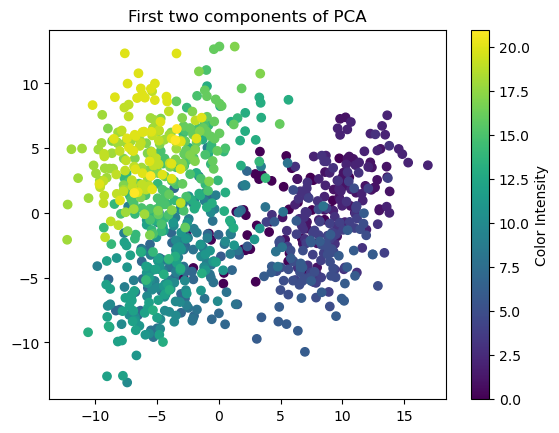

In [10]:
plt.title("First two components of PCA")
scatter = plt.scatter(pca_data['first_comp'], pca_data['second_comp'], c=pca_data['group'])
plt.colorbar(scatter, label = 'Color Intensity')

                                                    Radius of Gyration 

Text(0, 0.5, 'Radius of Gyration $[\\AA]$')

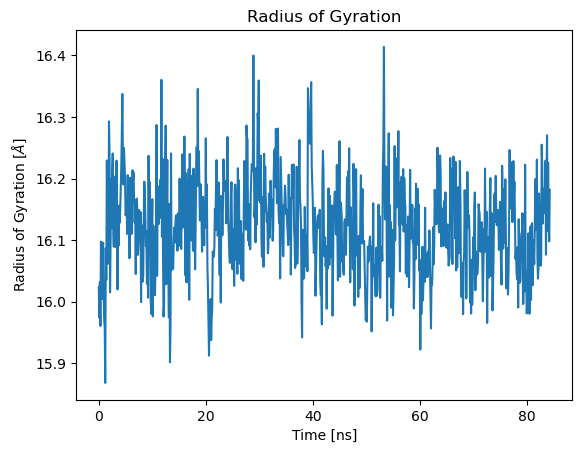

In [12]:
atom_group = aligned_traj.select_atoms(sel)

radii_o_gyr = []

for ts in aligned_traj.trajectory:
    rg = atom_group.radius_of_gyration()
    radii_o_gyr.append(rg)

plt.title('Radius of Gyration')
plt.plot(np.arange(len(radii_o_gyr)) / 10, radii_o_gyr)
plt.xlabel('Time [ns]')
plt.ylabel(r'Radius of Gyration $[\AA]$')

In [ ]:
# export to csv the radius of gyration, rmsf, rmsd in order to compare them to the 3eig things
export_path = "/home/giacomo/comp_bio/cbp_final/data/03_analyzed/"

toexport_RMSD = pd.DataFrame({"rmsd": R.results.rmsd[:,2]})
toexport_RMSF = pd.DataFrame({"rmsf": RF.results.rmsf})
toexport_rgyr = pd.DataFrame({"rgyr": radii_o_gyr})
toexport_rgyr_pocket = pd.DataFrame({"rgyr": radii_o_gyr_pocket})

toexport_RMSD.to_csv(export_path + "rmsd.csv")
toexport_RMSF.to_csv(export_path + "rmsf.csv")
toexport_rgyr.to_csv(export_path + "rgyr.csv")
toexport_rgyr_pocket.to_csv(export_path + "rgyr_pocket.csv")